# Predicting sport specific performance from field testing in synchronized swimming
Romain Martinez ([GitHub](https://github.com/romainmartinez))

In [100]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
NORMALIZE = 'False'

## Get the data

In [4]:
DATA_PATH = Path("./data/zTable.xlsx")
df = pd.read_excel(DATA_PATH)

df.head()

,Name,Height,Weight,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,...,FLEX/D,EB max force,EB mean force,EB sd force,EB max height,EB min height,EB mean height,EB sd height,EB max-min height,BB
0,'aissatou_sougou',1.69,48.52,287.05,285.00,206.85,179.90,92.85,94.95,52.3,...,146.00,8.33,6.770000,0.439447,8.5,7.5,8.083333,0.376386,1.0,9.5
1,'anais_charland',1.63,62.13,292.75,302.75,239.85,207.85,109.25,103.25,98.4,...,123.35,9.43,7.762753,0.584721,7.5,7.0,7.083333,0.204124,0.5,8.5
2,'anne sophie_moreau',1.71,54.90,252.40,258.55,233.45,233.65,69.30,68.80,120.0,...,204.80,8.76,6.725683,0.767079,8.0,7.5,7.833333,0.258199,0.5,8.5
3,'audrey_lamothe',1.50,43.44,213.45,227.40,174.00,132.10,54.20,56.40,39.9,...,112.25,9.86,7.315823,0.815853,8.0,7.0,7.416667,0.376386,1.0,8.5
4,'billie_francis',1.78,62.04,281.75,296.20,258.65,227.25,97.25,99.05,77.2,...,152.85,10.77,8.995158,0.570680,7.5,7.0,7.333333,0.258199,0.5,9.0


In [8]:
# variables
variables = [
    "ADD/G",
    "ADD/D",
    "ABD/G",
    "ABD/D",
    "ER/G",
    "ER/D",
    "IR/G",
    "IR/D",
    "EXT/G",
    "EXT/D",
    "FLEX/G",
    "FLEX/D",
]
X = df[variables] / 9.81
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
3,21.758410,23.180428,17.737003,13.465851,5.524975,5.749235,4.067278,3.792049,14.123344,0.203874,12.003058,11.442406
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040


In [9]:
targets = ["BB", "EB mean height", "EB mean force"]
y = df[targets].rename(
    columns={"BB": "BB-H", "EB mean height": "EB-H", "EB mean force": "EB-F"}
)
y.head()

,BB-H,EB-H,EB-F
0,9.5,8.083333,6.770000
1,8.5,7.083333,7.762753
2,8.5,7.833333,6.725683
3,8.5,7.416667,7.315823
4,9.0,7.333333,8.995158


## Normalize data
We should normalize the field tests (`X`) by anthropometric measurements.

In [10]:
if NORMALIZE == "weight":
    normalizer = df["Weight"]
elif NORMALIZE == "IMC":
    normalizer = df["Weight"] / df["Height"] ** 2
elif NORMALIZE == "weight-height":
    normalizer = df["Weight"] * df["Height"]
else:
    normalizer = 1
    print("data not normalized")
X = X.divide(normalizer, axis=0)

data not normalized


## NaN remover

In [11]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "32.95107033639144"
participant no.: 41
	test: IR/G
		"nan" replace by "12.125382262996942"
participant no.: 90
	test: IR/G
		"nan" replace by "9.403669724770642"


## Data description

### Variables $X$
Hip strength tests (field testing):
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test

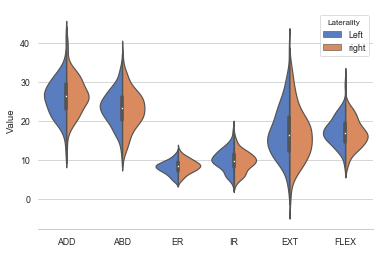

In [12]:
v = sns.violinplot(
    x="test",
    y="value",
    hue="Laterality",
    split=True,
    inner="box",
    scale="count",
    palette="muted",
    data=X.melt().assign(
        test=lambda x: x["variable"].str.split("/").str[0],
        Laterality=lambda x: x["variable"]
        .str.split("/")
        .str[1]
        .replace({"D": "right", "G": "Left"}),
    ),
)
v.set(xlabel="", ylabel="Value")
sns.despine(left=True)


v.figure.savefig("./share/fig/X.png", dpi=300)

### Targets $y$

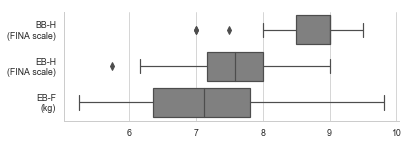

In [13]:
# v = sns.violinplot(scale="count", split=True, color="grey", inner="box", data=y)
plt.figure(figsize=(6, 2))
v = sns.boxplot(color="grey", orient='h', data=y)
v.set(
    xlabel="",
    ylabel="",
    yticklabels=["BB-H\n(FINA scale)", "EB-H\n(FINA scale)", "EB-F\n(kg)"],
)
sns.despine()
plt.savefig('./share/fig/y.png', dpi=300)

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [14]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance

In [15]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [16]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

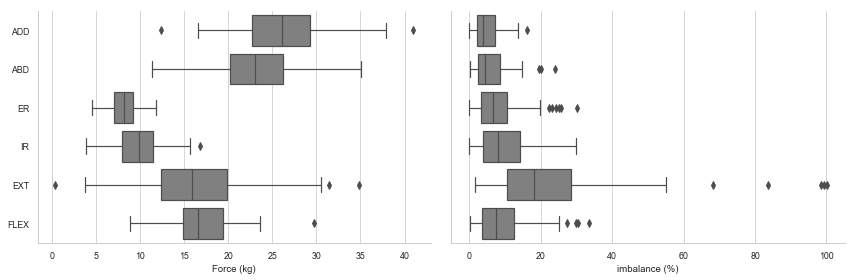

In [17]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] == "i"]],
    orient="h",
    color="grey",
    ax=ax[1],
)
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] != "i"]],
    orient="h",
    color="grey",
    ax=ax[0],
)
ax[0].set_xlabel("Force (kg)")
ax[1].set_xlabel("imbalance (%)")
plt.tight_layout()
sns.despine()
plt.savefig('./share/fig/X.png', dpi=300)

## Fitting an ensemble model

In [18]:
X_augmented['Height'] = df['Height']
X_augmented['Weight'] = df['Weight']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=RANDOM_SEED
)

### Helper functions

In [20]:
from sklearn.metrics import mean_squared_error


def mape(y_test, y_pred):
    return (np.abs((y_test - y_pred) / y_test)) * 100


def mae(y_test, y_pred):
    return np.abs(y_test - y_pred)


def evaluate(y_test, y_pred):
    d = {"mae": mae(y_test, y_pred), "mape": mape(y_test, y_pred)}
    print(
        f"""
    \tmae = {d['mae'].mean():.3f} ({d['mae'].std():.3f})
    \tmape = {d['mape'].mean():.3f}% ({d['mape'].std():.3f})
    """
    )
    return d

In [21]:
# from skopt import BayesSearchCV, dump, load


# class BayesSearch:
#     def __init__(self, model, search_spaces, n_iter, export_path):
#         self.export_path = export_path
#         self.bayes_cv_tuner = BayesSearchCV(
#             model,
#             search_spaces,
#             cv=5,
#             n_jobs=-1,
#             n_iter=n_iter,
#             verbose=0,
#             refit=True,
#             random_state=RANDOM_SEED,
#         )

#     def fit(self, X, y):
#         self.bayes_cv_tuner.fit(X, y, callback=self.print_status)
#         self.export_results()

#     def export_results(self):
#         pd.DataFrame(self.bayes_cv_tuner.cv_results_).to_csv(
#             f"{self.export_path}_cv_results.csv"
#         )
#         pd.Series(self.bayes_cv_tuner.best_params_).to_json(
#             f"{self.export_path}_best_params.json"
#         )
#         dump(self.bayes_cv_tuner, f"{self.export_path}_bayes_search.pkl")

#     def print_status(self, optim_results):
#         print(
#             f"""
# Model #{len(opt.bayes_cv_tuner.cv_results_['params'])}
# Best: {self.bayes_cv_tuner.best_score_}
# Best params: {self.bayes_cv_tuner.best_params_}
#         """
#         )

### Fit model

In [22]:
from xgboost import XGBRegressor

OPT = False
ITERATIONS = 100

params = {"n_jobs": 1, "silent": 1, "tree_method": "approx"}

if OPT:
    for itarget in y.columns:
        OPT_EXPORT = f"opt/{itarget}"

        search_spaces = {
            "learning_rate": (0.01, 1.0, "log-uniform"),
            "min_child_weight": (0, 10),
            "max_depth": (0, 50),
            "max_delta_step": (0, 20),
            "subsample": (0.01, 1.0, "uniform"),
            "colsample_bytree": (0.01, 1.0, "uniform"),
            "colsample_bylevel": (0.01, 1.0, "un|iform"),
            "reg_lambda": (1e-9, 1000, "log-uniform"),
            "reg_alpha": (1e-9, 1.0, "log-uniform"),
            "gamma": (1e-9, 0.5, "log-uniform"),
            "min_child_weight": (0, 5),
            "n_estimators": (50, 100),
            "scale_pos_weight": (1e-6, 500, "log-uniform"),
        }

        opt = BayesSearch(
            model=XGBRegressor(**params),
            search_spaces=search_spaces,
            n_iter=ITERATIONS,
            export_path=OPT_EXPORT,
        )
        opt.fit(X_train, y_train[itarget])

In [23]:
USE_OPT = False

boosted = {}
evaluation = {}

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)

for itarget, itarget_name in enumerate(y_train.columns):
    print(f"\t{itarget}. {itarget_name}\n")

    opt_params = (
        load(f"opt/{itarget_name}_bayes_search.pkl").best_params_ if USE_OPT else {}
    )

    boosted[itarget_name] = XGBRegressor(
        **{**params, **opt_params}, random_state=RANDOM_SEED
    )
    boosted[itarget_name].fit(
        X_train,
        y_train[itarget_name],
        eval_set=[(X_train, y_train[itarget_name]), (X_test, y_test[itarget_name])],
        early_stopping_rounds=50,
        eval_metric="rmse",
        verbose=50,
    )

    evaluation[itarget_name] = evaluate(
        y_test[itarget_name], boosted[itarget_name].predict(X_test)
    )
    evaluation[itarget_name]["test"] = [
        itarget_name for i in range(len(evaluation[itarget_name]["mae"]))
    ]

    print(f'{"-" * 30}\n')
evaluation = pd.concat([pd.DataFrame(evaluation[itest]) for itest in evaluation.keys()])

	0. BB-H

[15:43:01] Tree method is selected to be 'approx'
[0]	validation_0-rmse:7.41009	validation_1-rmse:7.61465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.200503	validation_1-rmse:0.567182
[99]	validation_0-rmse:0.070975	validation_1-rmse:0.525167

    	mae = 0.457 (0.265)
    	mape = 5.122% (2.926)
    
------------------------------

	1. EB-H

[15:43:01] Tree method is selected to be 'approx'
[0]	validation_0-rmse:6.40972	validation_1-rmse:6.18042
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.18701	validation_1-rmse:0.598762
Stopping. Best iteration:
[43]	validation_0-rmse:0.236542	validation_1-rmse:0.592042


    	mae = 0.473 (0.365)
    	mape = 6.723% (5.778)
    
------------------------------

	2. EB-F

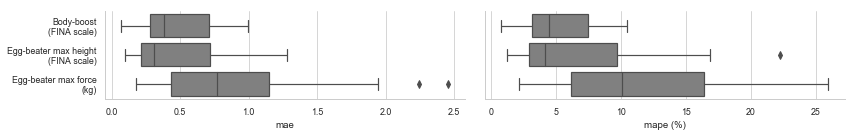

In [24]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 2))
sns.boxplot(y="test", x="mae", data=evaluation, ax=ax[0], orient="h", color="grey")
sns.boxplot(y="test", x="mape", data=evaluation, ax=ax[1], orient="h", color="grey")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("mape (%)")
# TODO: %

ax[0].set_yticklabels(
    [
        "Body-boost\n(FINA scale)",
        "Egg-beater max height\n(FINA scale)",
        "Egg-beater max force\n(kg)",
    ]
)
plt.tight_layout()
sns.despine()
plt.savefig('./share/fig/eval.png', dpi=300)

In [25]:
evaluation.groupby('test').mean()['mape'].sum()

23.90606336461242

## Interpretation

In [26]:
import shap

shap.initjs()

explainer = {itarget: shap.TreeExplainer(boosted[itarget]) for itarget in y.columns}
shap_values = {
    itarget: explainer[itarget].shap_values(X_augmented) for itarget in y.columns
}

### How important are our features?
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

In [27]:
shap_df = pd.concat(
    [
        pd.DataFrame(shap_values[i], columns=X_train.columns).assign(target=i)
        for i in y.columns
    ]
)

In [28]:
shap_df_abs = shap_df.copy()
shap_df_abs[X_train.columns] = shap_df_abs[X_train.columns].abs()

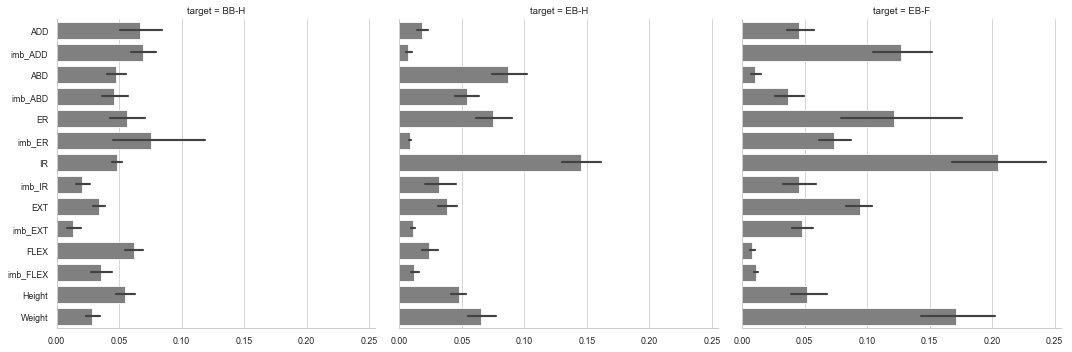

In [29]:
shap_df_abs = shap_df.copy()
shap_df_abs[X_train.columns] = shap_df_abs[X_train.columns].abs()
sns.catplot(col="target", data=shap_df_abs, color="grey", kind="bar", orient="h")

sns.despine()

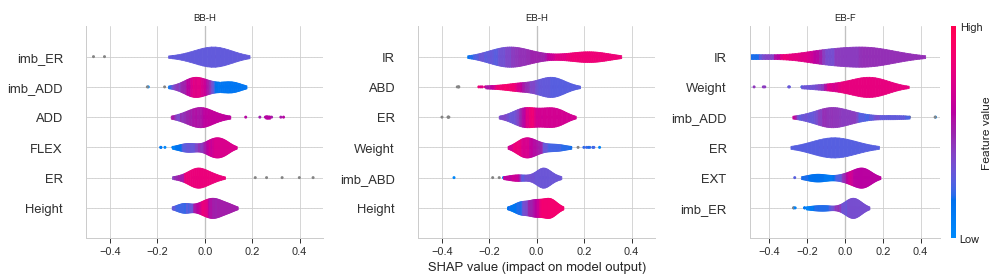

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
MAX_DISPLAY = 6

for i, itarget in enumerate(y.columns):
    color_bar = True if i == 2 else False

    plt.sca(ax[i])
    shap.summary_plot(
        shap_values[itarget],
        X_augmented,
        show=False,
        color_bar=color_bar,
        auto_size_plot=False,
        max_display=MAX_DISPLAY,
        plot_type="violin",
    )
    ax[i].set_title(itarget)
    ax[i].set_xlim(-0.5, 0.5)
    if i != 1:
        ax[i].set_xlabel("")
plt.tight_layout()
sns.despine()
plt.savefig('./share/fig/shap.png', dpi=300)

---

In [205]:
from platypus import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

VAR = 'BB-H'
candidate_idx = 15

candidate_height = X_augmented.iloc[candidate_idx, 12]
Initial_obs = X_augmented.iloc[[candidate_idx]].drop(columns=['Height'])
BB_H_initial = boosted[VAR].predict(X_augmented.iloc[[candidate_idx]])

desired= BB_H_initial+0.5

shap_weight = np.delete(np.mean(np.abs(shap_values[VAR]), axis=0),12)
shap_ponderation = 1-shap_weight/np.sum(shap_weight)

n_var = X_augmented.shape[1] - 1
n_obj = 3

class Opt(Problem):
    def __init__(self):
        super(Opt,self).__init__(n_var, n_obj)
        self.types[0:11:2] = Real(0.6, 1.4)
        self.types[1:12:2] = Real(0.4, 1)
        self.types[12] = Real(0.8, 1.2)
    def evaluate(self, solution):
        x = solution.variables[:]
        real_x = x*Initial_obs
        Obs_variation = real_x.sub(Initial_obs, fill_value=0).abs()
        real_x.insert(12, "Height", candidate_height)
        Weighted_Obs_variation = Obs_variation*shap_ponderation
        Force_Obs_variation = Obs_variation
        Force_Obs_variation = (Force_Obs_variation/shap_ponderation).drop(columns=['imb_ADD', 'imb_ABD', 'imb_ER', 'imb_IR',
                                                                                   'imb_EXT', 'imb_FLEX', 'Weight'])
        Imb_Obs_variation = (Obs_variation*shap_ponderation).drop(columns=['ADD', 'ABD', 'ER', 'IR', 'EXT', 'FLEX'])
        New_var = boosted[VAR].predict(real_x)
#         solution.objectives[:] = np.append(np.abs(New_var-desired), np.sum(Weighted_Obs_variation.values))
        solution.objectives[:] = np.append(np.abs(New_var-desired), [np.sum(Force_Obs_variation.values),
                                                                     np.sum(Imb_Obs_variation.values)])
        
algorithm = SMPSO(Opt())
algorithm.run(90000)

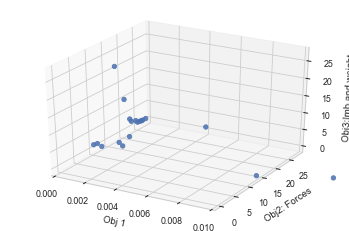

In [206]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plt.scatter([s.objectives[0] for s in algorithm.result],[s.objectives[1] for s in algorithm.result])
 
ax.scatter([s.objectives[0] for s in algorithm.result],
            [s.objectives[1] for s in algorithm.result],
            [s.objectives[2] for s in algorithm.result]
          )  
ax.set_xlabel('Obj 1')
ax.set_ylabel('Obj2: Forces')
ax.set_zlabel('Obj3:Imb and weight')
ax.set_xlim([0,0.01])
# plt.axis([0,0.1, 0, 15])
plt.show()

In [183]:
def Left_Force(a,b):
    return a*(200-b)/(200-2*b)

def Right_Force(b,L):
    return L*(100-b)/100

In [162]:
TESTS = ['ADD', 'ABD', "ER", "IR", "EXT", "FLEX"]

In [99]:
X_augmented[TESTS].sum(axis=1).sort_values(ascending=False)

33    156.044186
31    147.014295
9     139.268846
52    134.647222
5     130.863555
77    128.147738
54    124.861397
50    123.379674
60    123.042034
62    121.411827
55    121.034141
41    120.207504
83    119.209961
90    118.709434
43    117.494394
91    116.622141
1     115.765982
66    115.531739
16    115.464272
59    115.424426
76    114.654737
48    113.783811
39    113.557467
32    112.640348
53    112.406714
68    111.175995
34    110.488853
74    110.075938
38    109.304072
14    109.061630
         ...    
51     93.064743
46     92.931400
87     92.012725
37     91.836909
78     91.558365
10     90.008190
40     89.792408
22     89.257511
18     87.940801
89     87.700689
11     87.263131
79     87.075834
15     86.385842
42     85.571643
71     85.216239
56     85.120525
75     84.611650
23     81.913873
84     79.979090
44     78.957215
58     77.132278
29     75.570739
13     75.447241
24     71.508157
86     68.638191
6      63.269325
49     61.202591
12     59.8089

In [207]:
Relative = False
output_path = f"./Evolutionary/_{candidate_idx}_{VAR}.txt"

output = pd.DataFrame(columns= ['ADD/G','ADD/D','ABD/G','ABD/D','ER/G','ER/D','IR/G','IR/D','EXT/G',
                                'EXT/D','FLEX/G','FLEX/D','Weight', 'Obj_principal', 'Obj_Forces', 'Obj_Imb'])
if Relative:
    for solution in unique(nondominated(algorithm.result)):
        Row = list()
        Left = list()
        Right = list()
        for n in range(6):
            Left = Left_Force(solution.variables[2*n], solution.variables[2*n+1])
            Right = Right_Force(solution.variables[2*n+1],Left)
            Row += [Left]
            Row += [Right]
        Row.extend([solution.variables[12], solution.objectives[0], solution.objectives[1], solution.objectives[2]])
        output.loc[len(output)] = Row
else:
    for solution in unique(nondominated(algorithm.result)):
        Row = list()
        Left = list()
        Right = list()
        for n in range(6):
            Left = Left_Force(solution.variables[2*n]*X_augmented.iloc[candidate_idx][2*n], solution.variables[2*n+1]*X_augmented.iloc[candidate_idx][2*n+1])
            Right = Right_Force(solution.variables[2*n+1]*X_augmented.iloc[candidate_idx][2*n+1],Left)
            Row += [Left]
            Row += [Right]
        Row.extend([solution.variables[12]*X_augmented.iloc[candidate_idx][13], solution.objectives[0], solution.objectives[1], solution.objectives[2]])
        output.loc[len(output)] = Row
    print(X.iloc[[0]])

output.to_csv(output_path, sep='\t')    
output.sort_values(by=['Obj_principal','Obj_Imb'])

       ADD/G      ADD/D      ABD/G     ABD/D      ER/G      ER/D      IR/G  \
0  29.260958  29.051988  21.085627  18.33843  9.464832  9.678899  5.331295   

       IR/D      EXT/G      EXT/D     FLEX/G     FLEX/D  
0  5.295617  16.987768  20.050968  18.654434  14.882773  


,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D,Weight,Obj_principal,Obj_Forces,Obj_Imb
1,28.880077,25.763614,13.281605,13.210994,5.110944,4.559017,5.115954,4.036856,10.045543,8.849849,19.559317,18.276844,53.933683,0.000077,27.547984,0.511322
46,28.300619,25.246686,13.423642,13.351331,5.246463,4.679752,5.178589,4.085916,10.123779,8.918401,19.290442,18.025599,53.879579,0.000077,26.494062,0.543484
85,28.514305,25.442133,13.016612,12.946493,5.262567,4.694116,5.116208,4.036697,11.610423,10.229437,19.520355,18.243261,53.891339,0.000077,26.014919,0.572628
60,28.893841,25.775892,13.635058,13.565495,5.183906,4.623952,5.614182,4.429600,11.622531,10.238706,19.881716,18.578104,53.778597,0.000077,25.559451,0.666024
31,28.307444,25.277039,14.029079,13.955206,5.188364,4.628371,5.491522,4.334576,10.779085,9.498047,19.169999,17.930682,53.874182,0.000077,24.727896,0.782002
44,28.042893,25.049309,14.382995,14.307321,5.320312,4.749262,5.463303,4.318550,10.465950,9.239292,18.763899,17.607296,53.721178,0.000077,24.127546,1.561329
38,28.295656,25.371436,14.762418,14.686344,5.152133,4.602062,5.834657,4.617320,11.355690,10.052076,18.763490,17.598236,53.818609,0.000077,22.605903,2.108111
5,28.028445,25.147011,15.291478,15.232259,5.239010,4.673104,5.951468,4.702898,11.429453,10.068617,19.149774,17.931993,52.167531,0.000077,22.081514,3.069117
4,28.130266,25.774718,17.021080,16.951881,5.905404,5.279937,7.105425,5.614705,12.332927,11.051211,19.425014,18.481756,59.327064,0.000212,19.703705,10.289595
35,27.914797,24.903137,18.052851,17.955613,6.154705,5.489998,6.964338,5.495098,16.177643,14.251855,16.165289,15.105656,54.534254,0.000278,11.697084,0.091113


NSGAII
    Opt
        Hypervolume : [0.43219]
CMAES
    Opt
        Hypervolume : [0.33217]
GDE3
    Opt
        Hypervolume : [0.55172]
MOEAD
    Opt
        Hypervolume : [0.372]
OMOPSO
    Opt
        Hypervolume : [0.20814]
SMPSO
    Opt
        Hypervolume : [0.24576]
SPEA2
    Opt
        Hypervolume : [0.55386]
EpsMOEA
    Opt
        Hypervolume : [0.48925]


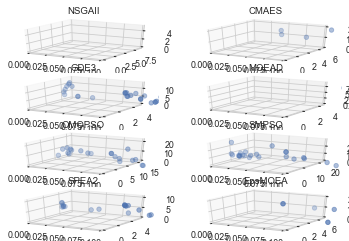

In [139]:
from platypus import *

if __name__ == '__main__':
    pbl = Opt()
    algo = [NSGAII,
            (CMAES, {"epsilons": [0.05]}),
            GDE3,
            MOEAD,
            (OMOPSO, {"epsilons": [0.05]}),
            SMPSO,
            SPEA2,
            (EpsMOEA, {"epsilons": [0.05]})
           ]
    
    with ProcessPoolEvaluator() as evaluator:
        results = experiment(algo, pbl, seeds=1, nfe=10000)
        
#     hyp = Hypervolume(minimum=[0, 0, 0], maximum=[0.5, 5, 12])
#     hyp_result = calculate(results, hyp)
#     display(hyp_result, ndigits=5)
    
    fig = plt.figure()
    
    for i, algo in enumerate(six.iterkeys(results)):
        result = results[algo]["Opt"][0]
        
        ax = fig.add_subplot(4, 2, i+1, projection='3d')
        ax.scatter([s.objectives[0] for s in result],
                   [s.objectives[1] for s in result],
                   [s.objectives[2] for s in result])
        ax.set_title(algo)
        ax.set_xlim([0, 0.1])
        ax.locator_params(nbins=2)
    
    plt.show()

In [212]:
X.iloc[:2]
np.mean(np.abs(shap_values[VAR]), axis=0)
ROW = X_augmented.iloc[[29]]
# Use a function
def plot_radar_from_active(row, title, color, cand, participante):
    # Background
    N = 12
    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(3, 3, row+1, polar=True)
    plt.xticks(angles, list(X)[:], color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=8)
    plt.ylim(0,40)
    # Plots
    # Before
    values = X.iloc[[participante]].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=0.5, linestyle='solid', label="Before")
    ax.fill(angles, values, color = color, alpha=0.1)
    
    plt.title(title, size=11, color=color, y=1.1)
    # After
    best = 0
    values=output.iloc[cand][:12].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'b', linewidth=0.5, linestyle='solid', label="After")
    ax.fill(angles, values, 'b', alpha=0.1)

my_dpi = 300
plt.figure(figsize = (4500/my_dpi,3600/my_dpi), dpi=my_dpi)
cdt = [1]
for row in range(0, len(cdt)):
#     t = "Candidate %d solution %d Objectif I %d " % (candidate_idx, cdt[row], output.iloc[cdt[row]][13])
    t=''
    plot_radar(row=row, title=t, color = 'r', cand=cdt[row], participante=candidate_idx )
plt.legend(loc='lower right', bbox_to_anchor=(-0.1,-0.1))

plt.savefig("Resultat_15_1.svg")

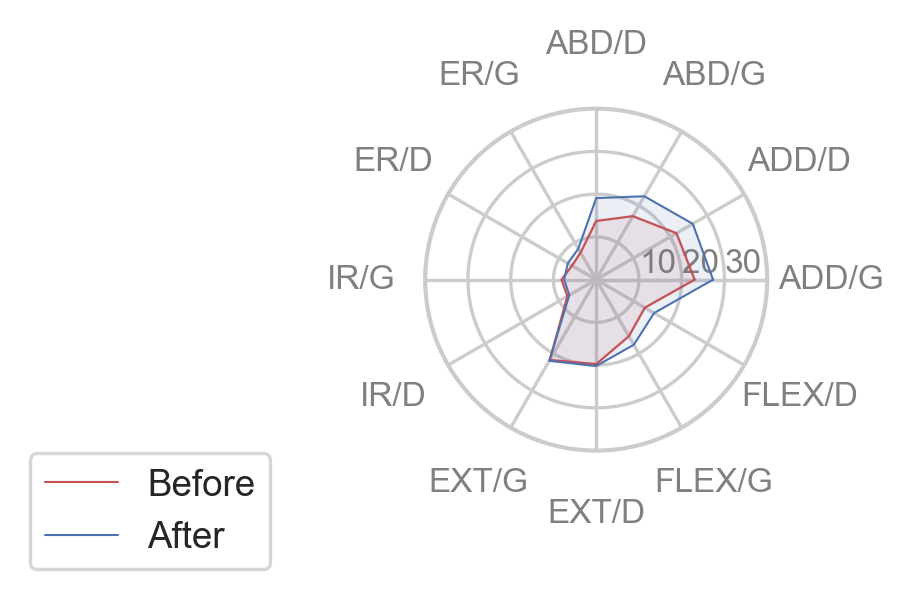

In [246]:
def plot_radar_from_file(row, title, cand, participante):
    # Background
    my_dpi = 300
    plt.figure(figsize = (2
                          500/my_dpi,3600/my_dpi), dpi=my_dpi)
    N = 12
    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(3, 3, row+1, polar=True)
    plt.xticks(angles, list(X)[:], color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=8)
    plt.ylim(0,40)
    # Load and sort file
    file_path = f"./Evolutionary/_{participante}_{VAR}.txt"
    d_print = pd.read_csv(file_path, sep='\t')
    d_print.sort_values(by=['Obj_principal','Obj_Imb'])
    d_print = d_print.reset_index(drop=True)
    # Plots
        # Before
    values = X.iloc[[participante]].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='r', linewidth=0.5, linestyle='solid', label="Before")
    ax.fill(angles, values, color = 'r', alpha=0.1)
    
    plt.title(title, size=11, y=1.1)
        # After
    best = 0
    values=d_print.iloc[cand][1:13].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'b', linewidth=0.5, linestyle='solid', label="After")
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.legend(loc='lower right', bbox_to_anchor=(-0.1,-0.1))
    plt.savefig("Resultat_%d_%d.svg" %(participante, cdt[row]))

participante = 11
t = ''
cdt = [0]
for row in range(0, len(cdt)):
     plot_radar_from_file(row, title=t, cand=cdt[row], participante=participante)


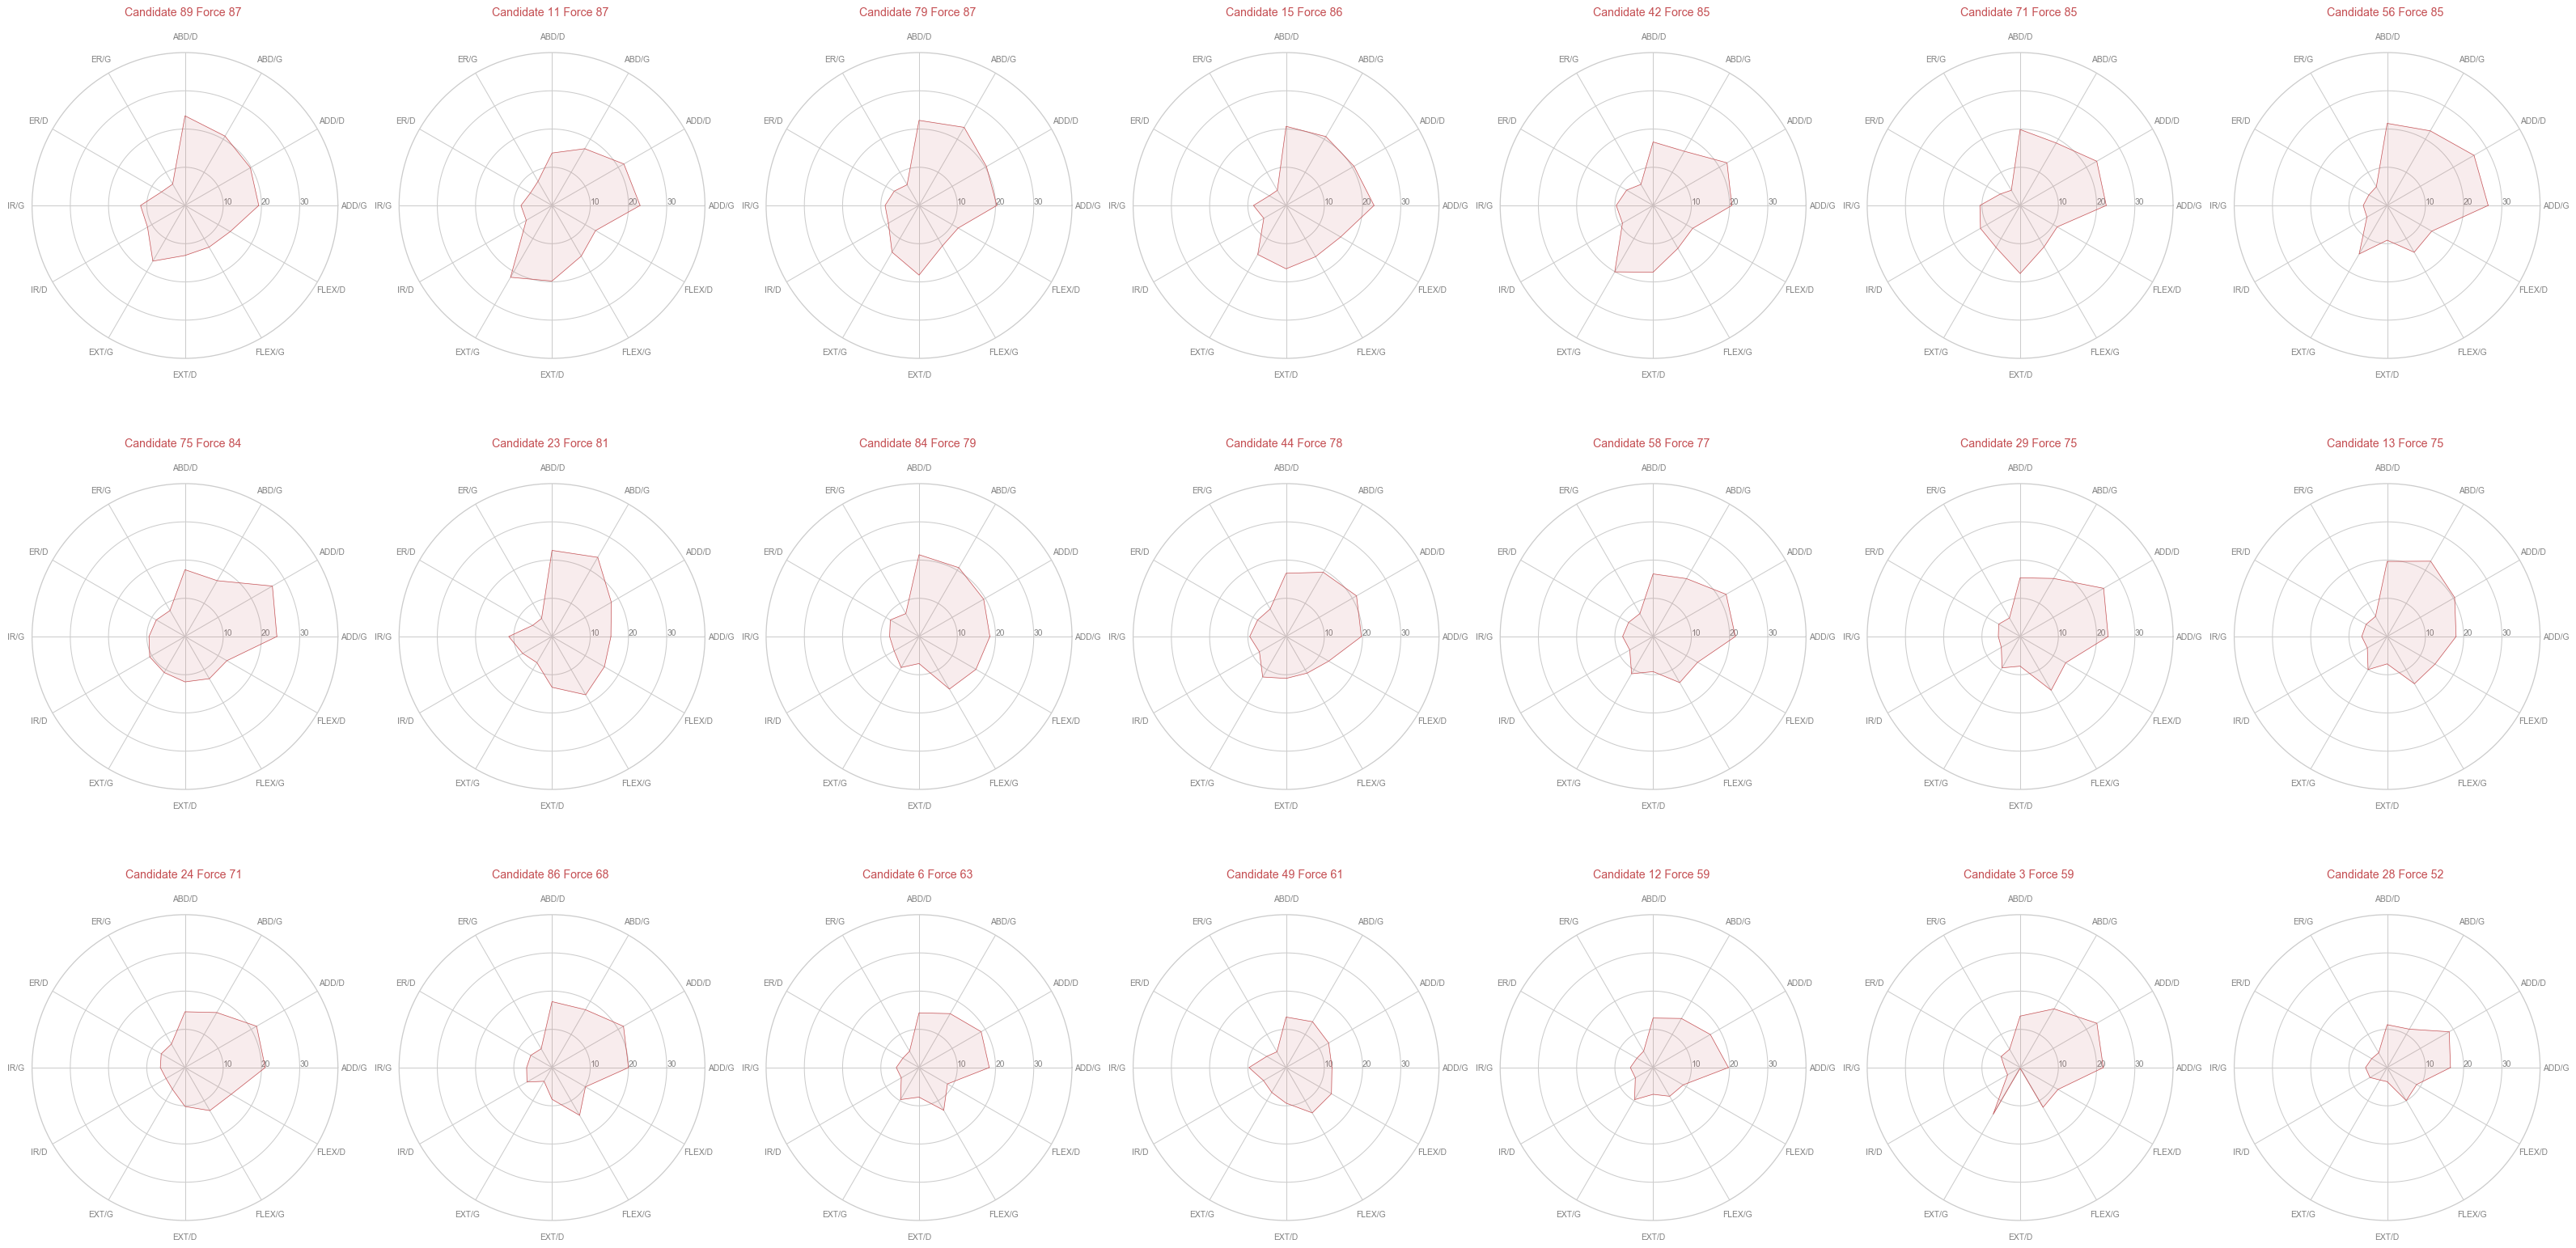

In [234]:
X.iloc[:2]
np.mean(np.abs(shap_values[VAR]), axis=0)
ROW = X_augmented.iloc[[29]]
# Use a function
def plot_radar(row, title, color, cand):
    # Background
    N = 12
    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(3, 7, row+1, polar=True)
    plt.xticks(angles, list(X)[:], color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=8)
    plt.ylim(0,40)
    # Plots
    # Before
    values = X.iloc[[cand]].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=0.5, linestyle='solid', label="Before")
    ax.fill(angles, values, color = color, alpha=0.1)
    
    plt.title(title, size=11, color=color, y=1.1)
    # After
    # best = 0
    # values=output.iloc[best][:12].values.flatten().tolist()
    # values += values[:1]
    # ax.plot(angles, values, 'b', linewidth=0.5, linestyle='solid', label="After")
    # ax.fill(angles, values, 'b', alpha=0.1)

my_dpi = 93
plt.figure(figsize = (4000/my_dpi, 2000/my_dpi), dpi=my_dpi)
cdt = [89,11,79,15,42,71,56,75,23,84,44,58,29,13,24,86,6,49,12,3,28]
for row in range(0, len(cdt)):
    t = "Candidate %s Force %d " % (cdt[row],X_augmented[TESTS].sum(axis=1)[cdt[row]])
    plot_radar(row=row, title=t, color = 'r', cand=cdt[row])
    # plt.legend(loc='lower right', bbox_to_anchor=(-0.1,-0.1))

plt.savefig("Plus_faible.svg")

### What is the prediction path?
The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [34]:
random_observation = np.random.randint(0, X_augmented.shape[0])

itarget = y.columns[0]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [35]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [36]:
shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

In [37]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [38]:
itarget = targets[2]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

KeyError: 'EB mean force'

In [ ]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

### How is target variable related with important features?
The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all observations we can see how changes in the feature's value effect the model's output.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in fatigue as AveShEleMean changes.

Vertical dispersion at a single value of AveShEleMean represents interaction effects with other features.

To help reveal these interactions dependence_plot automatically selects another feature for coloring.

In this case coloring by ROMTrYMean highlights that AveShEleMean has less impact on fatigue when ROMTrXMean decreases and conversely.

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))

for irow, itarget in enumerate(y.columns):
    # sort the features indexes by their importance in the model
    # (sum of SHAP value magnitudes over the validation dataset)
    top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))

    # make SHAP plots of the three most important features and their best interaction
    for icol, idx in enumerate(top_inds[:3]):
        plt.sca(ax[irow, icol])

        shap.dependence_plot(
            idx,
            shap_values[itarget],
            X_augmented,
            dot_size=60,
            interaction_index=None,
            alpha=0.7,
            show=False,
        )
        ax[irow, icol].set_ylabel("")
    ax[irow, 0].set_ylabel(f"SHAP value for\n{itarget}")

plt.gcf().set_size_inches(14, 10)
sns.despine()

### Supervised clustering
Clustering people by their shap values leads to groups relevent to the prediction task at hand.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
itarget = y.columns[0]

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[itarget][:, :-1])
shap_embedded = TSNE(
    n_components=2, perplexity=50).fit_transform(shap_values[itarget][:, :-1])

In [ ]:
def plot_clusters(x, y, c, label, a):
    a.scatter(
        x, y, c=c, linewidth=0, alpha=0.8, s=60)
    PCM=a.get_children()[0]
    cb = plt.colorbar(PCM, label=label, aspect=40, orientation="horizontal", ax=a)
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    a.axis("off")

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,5))

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=np.sum(shap_values[itarget], axis=1),
    a=ax[0],
    label='Model output')

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][0]],
    a=ax[1],
    label=feature_importance[itarget][0])

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][1]],
    a=ax[2],
    label=feature_importance[itarget][1])

plt.show()